In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import os
import glob
import numpy as np
import PIL.Image as Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2


Next, the data loader

In [2]:

class PH2(torch.utils.data.Dataset):
    def __init__(self, set_type, transform, split=[60,20,20], seed=42, data_path="/dtu/datasets1/02514/PH2_Dataset_images"):
        'Initialization'
        self.transform = transform
        allpaths = np.array(sorted(os.listdir(data_path)))
        
        split = np.array(split, dtype=np.float32)
        split *= len(allpaths)/np.sum(split)
        split = np.cumsum(split)
        
        np.random.seed(seed)
        random_ordering = np.random.permutation(len(allpaths))
        train_idx = random_ordering[:int(split[0])]
        val_idx = random_ordering[int(split[0]):int(split[1])]
        test_idx = random_ordering[int(split[1]):]
        
        if set_type.lower() == "train":
            allpaths = allpaths[train_idx]
        elif set_type.lower() in ["val", "validation"]:
            allpaths = allpaths[val_idx]
        elif set_type.lower() == "test":
            allpaths = allpaths[test_idx]
        else:
            raise AttributeError
        
        self.label_paths = []
        self.image_paths = []
        
        for i, name in enumerate(allpaths):
            self.image_paths.append(os.path.join(data_path, name, name+"_Dermoscopic_Image", name+".bmp"))
            self.label_paths.append(os.path.join(data_path, name, name+"_lesion", name+"_lesion.bmp"))
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        mask_path = self.label_paths[idx]
        
        image = np.array(Image.open(image_path), dtype=np.uint8)
        mask = np.array(Image.open(mask_path), dtype=np.uint8)
        
        transformed = self.transform(image=image, mask=mask)
        X = transformed["image"]
        Y = transformed["mask"]
        return X, Y


def get_dataloaders_PH2(batch_size, num_workers=8, seed=42, data_path="/dtu/datasets1/02514/PH2_Dataset_images"):
    
    data_transform_val = A.Compose(
        [
            A.Normalize(mean=0.5, std=0.5),
            A.PadIfNeeded(min_height=576, min_width=576),
            A.CenterCrop(576, 576),
            ToTensorV2(),
        ]
    )
    data_transform_train = A.Compose(
        [
            A.Normalize(mean=0.5, std=0.5),
            A.PadIfNeeded(min_height=576, min_width=576),
            A.CenterCrop(576, 576),
            A.Rotate(limit=45, p=1.0),
            A.VerticalFlip(p=0.5),
            A.GridDistortion(p=0.75),
            A.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0, p=1.0),
            ToTensorV2(),
        ]
    )
    
    trainset = PH2("train", data_transform_train, seed=seed, data_path=data_path)
    valset = PH2("val", data_transform_val, seed=seed, data_path=data_path)
    testset = PH2("test", data_transform_val, seed=seed, data_path=data_path)
    
    trainloader = DataLoader(
        trainset, batch_size=batch_size, num_workers=num_workers, shuffle=False
    )
    valloader = DataLoader(
        valset, batch_size=batch_size, num_workers=num_workers
    )
    testloader = DataLoader(
        testset, batch_size=batch_size, num_workers=num_workers
    )

    return trainloader, valloader, testloader

In principle, the images could have different sizes. Let's resize them all to $128\times128$ pixels, using the torchvision Resize. 

In [3]:
batch_size = 4
train_loader, val_loader,_ = get_dataloaders_PH2(batch_size=batch_size, data_path="../data/PH2_Dataset_images")


Let's look at some images from the dataset!

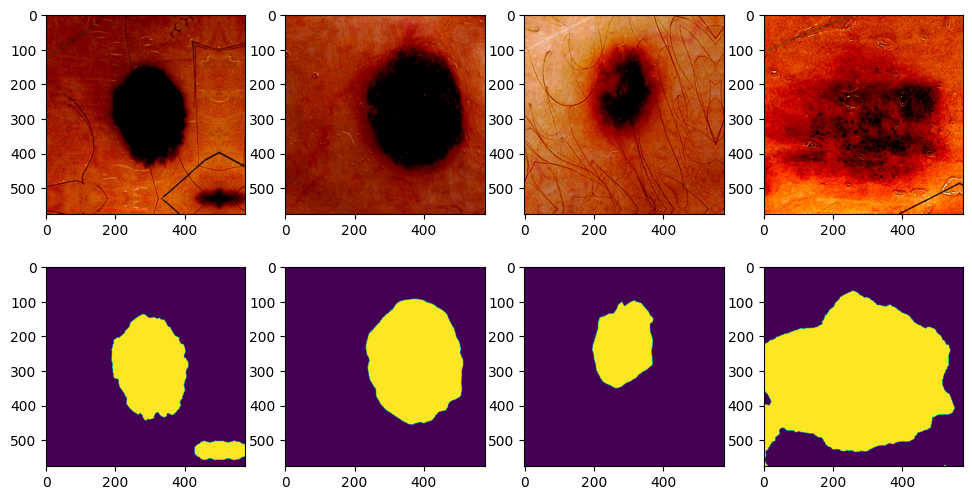

In [4]:
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(train_loader))

for i in range(4):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
plt.show()

## Device

Check if GPU is available.

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


First, we implement a simple encoder decoder network for image registration

In [6]:

def bce_loss(y_real, y_pred):
    y_real = y_real.squeeze()
    y_pred = y_pred.squeeze()
    good_mask = (-y_pred) < 50
    bad_mask = (-y_pred) >= 50

    loss_good = y_pred[good_mask] - y_real[good_mask]*y_pred[good_mask] + torch.log(1 + torch.exp(-y_pred[good_mask]))
    loss_bad = -y_real[bad_mask]*y_pred[bad_mask]
    loss = (torch.sum(loss_good)+torch.sum(loss_bad))/(y_real.numel())
    return loss


Can you still see situations in which this loss might be unstable? How would you change it?

## Training

We will define the training cycle in a function so we can re-use it.

In [7]:
def train(model, opt, loss_fn, epochs, train_loader, test_loader):
    X_test, Y_test = next(iter(test_loader))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch,Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_test.to(device))).detach().cpu()
        clear_output(wait=True)
        for k in range(4):
            plt.subplot(2, 4, k+1)
            plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 4, k+5)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
            plt.colorbar()
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Predict

After the model is trained, you can use this function to predict segmentations for new data:

In [8]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [9]:
def dice_loss(y_real, y_pred):
    y_pred = F.sigmoid(y_pred)
    loss = 1 - torch.mean(2*y_real*y_pred+1)/(torch.mean(y_real+y_pred) + 1)
    return loss

In [10]:
def focal_loss(y_real, y_pred, gamma=2):
    y_pred = F.sigmoid(y_pred)
    loss = -torch.mean(y_real*(1-y_pred)**gamma*torch.log(y_pred) + (1-y_real)*torch.log(1-y_pred))
    return loss

In [11]:
def bce_total_variation(y_real, y_pred):
    y_pred2 = F.sigmoid(y_pred)
    total_variation = torch.mean(torch.abs(y_pred2[:, :, :, :-1] - y_pred2[:, :, :, 1:])) + torch.mean(torch.abs(y_pred2[:, :, :-1, :] - y_pred2[:, :, 1:, :]))
    return bce_loss(y_real, y_pred) + 0.1*total_variation

In [12]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 64, 3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.Conv2d(64, 64, 3, stride=1, padding=1),
                                       nn.ReLU())
        
        self.downsample0 = nn.Conv2d(64, 64, 3, stride=2, padding=1)

        self.enc_conv1 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.Conv2d(128, 128, 3, stride=1, padding=1),
                                       nn.ReLU())
        self.downsample1 = nn.Conv2d(128, 128, 3, stride=2, padding=1)
        
        self.enc_conv2 = nn.Sequential(nn.Conv2d(128, 256, 3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, stride=1, padding=1),
                                       nn.ReLU())
        
        self.downsample2 = nn.Conv2d(256, 256, 3, stride=2, padding=1)
        
        self.enc_conv3 = nn.Sequential(nn.Conv2d(256, 512, 3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.Conv2d(512, 512, 3, stride=1, padding=1),
                                       nn.ReLU())
        
        self.downsample3 = nn.Conv2d(512, 512, 3, stride=2, padding=1)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(512, 1024, 3, stride=1, padding=1),
                                             nn.ReLU(),
                                             nn.Conv2d(1024, 1024, 3, stride=1, padding=1),
                                             nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        
        self.dec_conv0 = nn.Sequential(nn.Conv2d(1024, 512, 3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.Conv2d(512, 512, 3, stride=1, padding=1),
                                       nn.ReLU())
        
        self.upsample1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        
        self.dec_conv1 = nn.Sequential(nn.Conv2d(512, 256, 3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, stride=1, padding=1),
                                       nn.ReLU())
        
        self.upsample2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        
        self.dec_conv2 = nn.Sequential(nn.Conv2d(256, 128, 3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.Conv2d(128, 128, 3, stride=1, padding=1),
                                       nn.ReLU())
        
        self.upsample3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        
        self.dec_conv3 = nn.Sequential(nn.Conv2d(128, 64, 3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.Conv2d(64, 64, 3, stride=1, padding=1),
                                       nn.ReLU(),
                                       nn.Conv2d(64, 1, 1, stride=1))

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0_down = self.downsample0(e0)
        e1 = self.enc_conv1(e0_down)
        e1_down = self.downsample1(e1)
        e2 = self.enc_conv2(e1_down)
        e2_down = self.downsample2(e2)
        e3 = self.enc_conv3(e2_down)
        e3_down = self.downsample3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3_down)
        # decoder
        b = self.upsample0(b)
        b = torch.cat((b, e3), dim=1)  # skip-connection
        d0 = self.dec_conv0(b)

        d0 = self.upsample1(d0)

        d0 = torch.cat((d0, e2), dim=1)  # skip-connection
        d1 = self.dec_conv1(d0)

        d1 = self.upsample2(d1)

        d1 = torch.cat((d1, e1), dim=1)  # skip-connection
        d2 = self.dec_conv2(d1)

        d2 = self.upsample3(d2)

        d2 = torch.cat((d2, e0), dim=1)  # skip-connection
        d3 = self.dec_conv3(d2)  # no activation
        
        return d3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


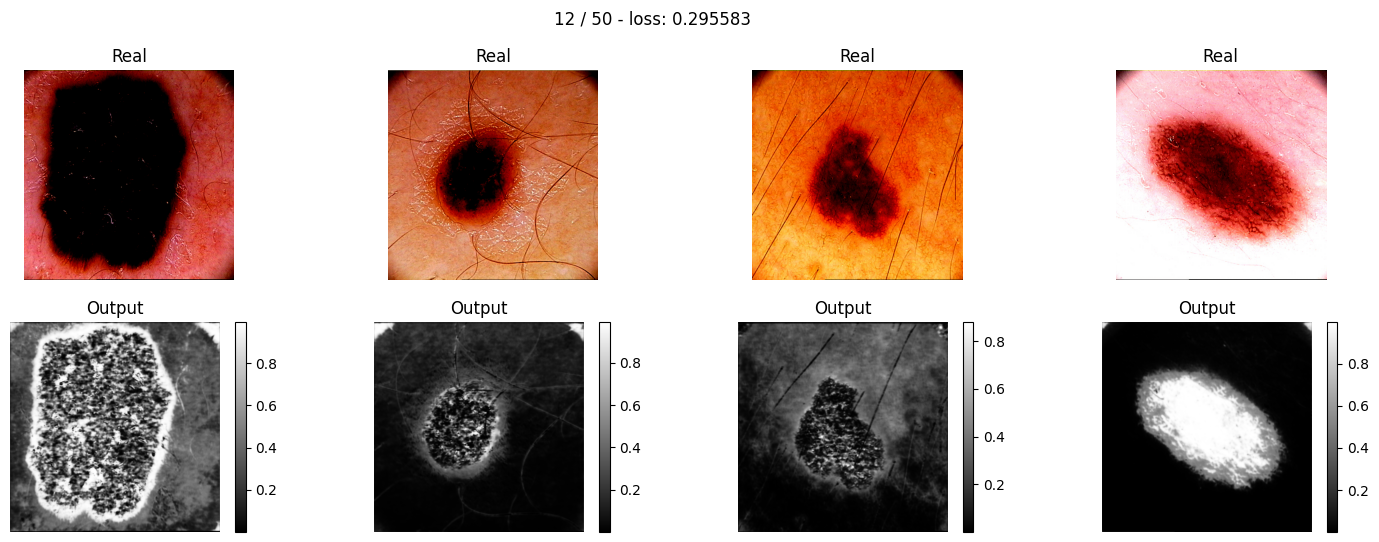

* Epoch 13/50


In [13]:
torch.cuda.empty_cache()
model = UNet2().to(device)
train(model, optim.Adam(model.parameters()), bce_loss, 50, train_loader, val_loader)